In [2]:
from __future__ import print_function , division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion #interactive mode

/home/ankit/anaconda3/envs/abc/lib/python3.5/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


<function matplotlib.pyplot.ion()>

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456, 0.406], [0.229, 0.224, 0.225 ])
    ]),
    'val':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),
}

data_dir ='/home/ankit/Downloads/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                         data_transforms[x]) 
                 for x in ['train', 'val']}
dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x],batch_size=4,
                                            shuffle=True, num_workers=4)
              for x in ['train','val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device= torch.device("cuda:0" if torch.cuda.is_available() else"cpu")


# Visualize a few Images

Let's visualize a  few training images so as to understand the data augmentations.

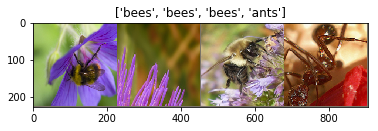

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std*inp +mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)#pause a bit so that plots are updated
    
    
#Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

#Make a grid from batch
out = torchvision.utils.make_grid(inputs)
   
imshow(out, title=[class_names[x] for x in classes])
    

# Training the MOdel



Now, let's write a general function to train a model. Here, we will illustrate:
.Scheduling the learning rate
.saving the best model

In the following, parameter scheduler is an LR scheduler object from torch.optim.lr_scheduler.

In [26]:
def train_model(model, criterion, optimizer,scheduler,num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc =0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('_' * 10)
        
        #Each epoch has a training and vailidation phase
        for phase in ['train','val']:
            if phase == 'train':
                scheduler.step()
                model.train() # Set model to training mode
                
            else:
                model.eval() # Set model to evaluate mode
                
            running_loss = 0.0
            running_corrects=0
            
            
            #Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                #Zero the paramete gradients
                optimizer.zero_grad()
                
                #forward
                #track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs,1)
                    loss = criterion(outputs,labels)
                    
                    #backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    #statistics
                    running_loss +=loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                        
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                    
                print('{}Loss:{:.4f} Acc: {:.4f}'.format(phase, 
                   epoch_loss, epoch_acc))
                    
                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                        
            print()
             
        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
                time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))
            
        #load best model weights
        model.load_state_dict(best_model_wts)
        return model         

# Visualizing the model predictions



Generic function to display predictions for a few images



In [31]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far=0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs=model(inputs)
            _, preds = torch.max(outputs,1)
            
            for j in range(inputs.size()[0]):
                images_so_far +=1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.trainmode=was_training
                    

# Finetuning the convnet



Load a pretrained model and reset final fully connected layer.

In [32]:
model_ft = models.resnet18(pretrained = True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion =nn.CrossEntropyLoss()

#Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(),lr=0.001, momentum=0.9)

#Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


# Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.

In [33]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                      num_epochs=25)

Epoch 0/24
__________
trainLoss:0.0153 Acc: 0.0041
trainLoss:0.0296 Acc: 0.0123
trainLoss:0.0411 Acc: 0.0205
trainLoss:0.0551 Acc: 0.0246
trainLoss:0.0663 Acc: 0.0369
trainLoss:0.0831 Acc: 0.0369
trainLoss:0.0973 Acc: 0.0451
trainLoss:0.1106 Acc: 0.0533
trainLoss:0.1201 Acc: 0.0656
trainLoss:0.1340 Acc: 0.0738
trainLoss:0.1430 Acc: 0.0861
trainLoss:0.1525 Acc: 0.0984
trainLoss:0.1592 Acc: 0.1107
trainLoss:0.1697 Acc: 0.1189
trainLoss:0.1772 Acc: 0.1352
trainLoss:0.1840 Acc: 0.1516
trainLoss:0.1973 Acc: 0.1598
trainLoss:0.2129 Acc: 0.1639
trainLoss:0.2308 Acc: 0.1721
trainLoss:0.2446 Acc: 0.1762
trainLoss:0.2518 Acc: 0.1885
trainLoss:0.2552 Acc: 0.2049
trainLoss:0.2662 Acc: 0.2131
trainLoss:0.2759 Acc: 0.2213
trainLoss:0.2864 Acc: 0.2336
trainLoss:0.3072 Acc: 0.2377
trainLoss:0.3205 Acc: 0.2459
trainLoss:0.3364 Acc: 0.2582
trainLoss:0.3456 Acc: 0.2664
trainLoss:0.3482 Acc: 0.2828
trainLoss:0.3718 Acc: 0.2869
trainLoss:0.3787 Acc: 0.2992
trainLoss:0.3835 Acc: 0.3115
trainLoss:0.4053 Acc:

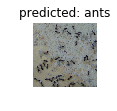

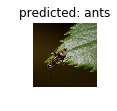

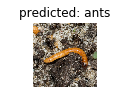

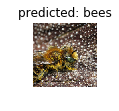

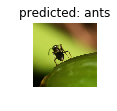

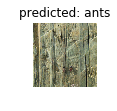

In [35]:
visualize_model(model_ft)


# ConvNet as fixed feature extractor

Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

You can read more about this in the documentation here.

In [37]:
model_conv = torchvision.models.resnet18(pretrained =True)
for param in model_conv.parameters():
    param.requires_grad = False
#Parameters of newly constructed modules have requires_grad= True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs,2)
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

#Observe that only parameters of final layer are being optimized as
#opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001,momentum=0.9)

#Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

# Train and evaluate

On CPU this will take about half the time compared to previous scenario. This is expected as gradients don’t need to be computed for most of the network. However, forward does need to be computed.

In [39]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                        exp_lr_scheduler, num_epochs=25)


Epoch 0/24
__________
trainLoss:0.0119 Acc: 0.0123
trainLoss:0.0267 Acc: 0.0164
trainLoss:0.0390 Acc: 0.0246
trainLoss:0.0503 Acc: 0.0369
trainLoss:0.0602 Acc: 0.0492
trainLoss:0.0705 Acc: 0.0615
trainLoss:0.0905 Acc: 0.0656
trainLoss:0.1004 Acc: 0.0779
trainLoss:0.1120 Acc: 0.0861
trainLoss:0.1192 Acc: 0.0984
trainLoss:0.1343 Acc: 0.1025
trainLoss:0.1467 Acc: 0.1066
trainLoss:0.1544 Acc: 0.1230
trainLoss:0.1640 Acc: 0.1352
trainLoss:0.1750 Acc: 0.1475
trainLoss:0.1838 Acc: 0.1598
trainLoss:0.1948 Acc: 0.1680
trainLoss:0.2023 Acc: 0.1803
trainLoss:0.2151 Acc: 0.1885
trainLoss:0.2264 Acc: 0.2008
trainLoss:0.2441 Acc: 0.2090
trainLoss:0.2495 Acc: 0.2254
trainLoss:0.2586 Acc: 0.2377
trainLoss:0.2653 Acc: 0.2500
trainLoss:0.2723 Acc: 0.2623
trainLoss:0.2768 Acc: 0.2746
trainLoss:0.2930 Acc: 0.2828
trainLoss:0.3025 Acc: 0.2951
trainLoss:0.3095 Acc: 0.3115
trainLoss:0.3129 Acc: 0.3279
trainLoss:0.3233 Acc: 0.3402
trainLoss:0.3358 Acc: 0.3484
trainLoss:0.3379 Acc: 0.3648
trainLoss:0.3426 Acc:

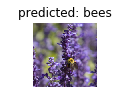

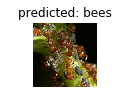

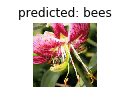

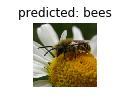

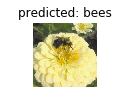

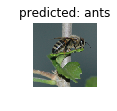

In [40]:
visualize_model(model_conv)

plt.ioff()
plt.show()
